### Analyzing Factors that Influence Plant Species Richness in the Galapagos ###

Build a robust regression model that explores the relationships between plant species richness and key predictors, such as:

- Island size (Area): Larger islands are generally expected to support more species due to greater habitat diversity and resource availability.
- Elevation: Plant species richness may exhibit a nonlinear relationship with elevation, often peaking at mid-level altitudes where ecological conditions are most favorable.
- Proximity to other islands (Nearest): Islands that are isolated ("Far") may have fewer species due to limited opportunities for species dispersal, while islands closer to others ("Near") may benefit from species migration and colonization.



In [2]:
# ! pip install faraway

# packages
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from faraway.datasets import galapagos

# Load the galapagos dataset
data = galapagos.load()

# Display the first few rows
print(data.head())

# Display the column names and data types
print(data.info())

# Statistics
print(data.describe())

           Species   Area  Elevation  Nearest  Scruz  Adjacent
Baltra          58  25.09        346      0.6    0.6      1.84
Bartolome       31   1.24        109      0.6   26.3    572.33
Caldwell         3   0.21        114      2.8   58.7      0.78
Champion        25   0.10         46      1.9   47.4      0.18
Coamano          2   0.05         77      1.9    1.9    903.82
<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, Baltra to Wolf
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Species    30 non-null     int64  
 1   Area       30 non-null     float64
 2   Elevation  30 non-null     int64  
 3   Nearest    30 non-null     float64
 4   Scruz      30 non-null     float64
 5   Adjacent   30 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 1.6+ KB
None
          Species         Area    Elevation    Nearest       Scruz  \
count   30.000000    30.000000    30.000000  30.000000   30.000000   
me

#### Fitting a Quadratic Model ####

The relationship between elevation and species count may be nonlinear. 

Formula: y = b<sub>0</sub> + b<sub>1</sub> x + b <sub>2</sub> x<sup>2</sup>

In [3]:
# Add a quadratic term for Elevation
data['Elevation2'] = data['Elevation'] ** 2

# Fit the model
quad_model = smf.ols(formula='Species ~ Elevation + Elevation2', data=data).fit()

# Print the summary
print(quad_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Species   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     23.56
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           1.20e-06
Time:                        11:33:17   Log-Likelihood:                -169.16
No. Observations:                  30   AIC:                             344.3
Df Residuals:                      27   BIC:                             348.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -28.9712     23.433     -1.236      0.2

#### Include Interaction Terms ####

Area and elevation may have a combined effect on species. 

Formula: y = b<sub>0</sub> + b<sub>1</sub> x<sub>1</sub> + b<sub>2</sub> x<sub>2</sub> + b<sub>3</sub> x<sub>2</sub>x<sub>2</sub>

In [4]:
# Fit the model with interaction terms
interaction_model = smf.ols(formula='Species ~ Area * Elevation', data=data).fit()

# Print the summary
print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Species   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     60.01
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           8.09e-12
Time:                        11:36:04   Log-Likelihood:                -153.26
No. Observations:                  30   AIC:                             314.5
Df Residuals:                      26   BIC:                             320.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.7666     11.374      2.

#### Add Indicator Variables ####

Splitting islands into near and far groups based on the Nearest variable.

- Near islands: Nearest <= median value; coded as 0
- Far islands: Nearest > median value; coded as 1


In [5]:
# Create binary `Near_Far` indicator variable
median_nearest = data['Nearest'].median()
data['Near_Far'] = np.where(data['Nearest'] > median_nearest, 1, 0)

# Verify new binary variable
print(data[['Nearest', 'Near_Far']].head())

# Fit the model
indicator_model = smf.ols(formula='Species ~ Area + Elevation + Near_Far', data=data).fit()

# Print the summary
print(indicator_model.summary())

           Nearest  Near_Far
Baltra         0.6         0
Bartolome      0.6         0
Caldwell       2.8         0
Champion       1.9         0
Coamano        1.9         0
                            OLS Regression Results                            
Dep. Variable:                Species   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     12.85
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           2.43e-05
Time:                        11:38:17   Log-Likelihood:                -170.67
No. Observations:                  30   AIC:                             349.3
Df Residuals:                      26   BIC:                             354.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err    

#### Apply Logarithmic Transformation ####

The Area variable appears to be skewed; a logarithmic transformation aligns it to the linearity assumption

Formula: y = b<sub>0</sub> + b<sub>1</sub> log(x) y

In [6]:
# Apply logarithmic transformation to Area
data['log_Area'] = np.log(data['Area'])

# Fit the log-transformed model
log_model = smf.ols(formula='Species ~ log_Area + Elevation + Near_Far', data=data).fit()

# Print the summary
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Species   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     20.97
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           4.08e-07
Time:                        11:41:03   Log-Likelihood:                -165.87
No. Observations:                  30   AIC:                             339.7
Df Residuals:                      26   BIC:                             345.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.4465     20.983      2.738      0.0

#### Model Diagnostics ####

Residual plot, normality of residuals, multicollinearity

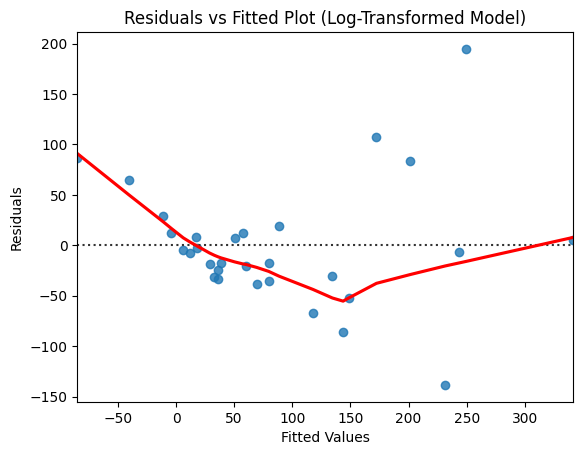

In [7]:
# Residuals vs Fitted plot
sns.residplot(x=log_model.fittedvalues, y=log_model.resid, lowess=True, line_kws={"color": "red"})
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Plot (Log-Transformed Model)")
plt.show()

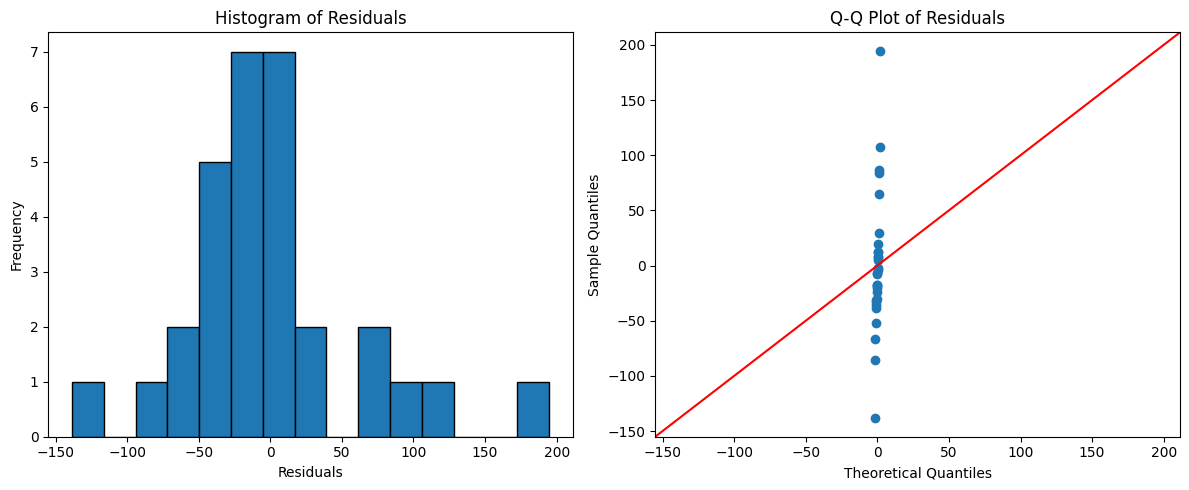

In [9]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Histogram of residuals
axes[0].hist(log_model.resid, bins=15, edgecolor='k')
axes[0].set_title("Histogram of Residuals")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Frequency")

# Q-Q plot
sm.qqplot(log_model.resid, line='45', ax=axes[1])  # Specify ax for Q-Q plot
axes[1].set_title("Q-Q Plot of Residuals")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Correlation Matrix:
           log_Area  Elevation  Near_Far
log_Area   1.000000   0.816824  0.049677
Elevation  0.816824   1.000000  0.006514
Near_Far   0.049677   0.006514  1.000000


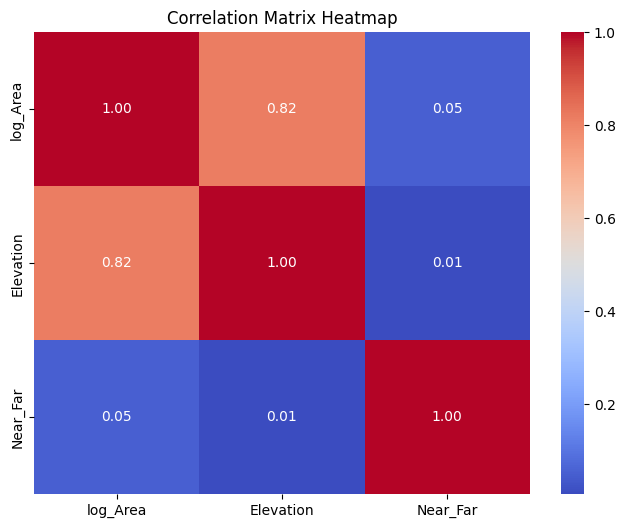


VIF:
    Variable       VIF
0      const  3.082088
1   log_Area  3.022692
2  Elevation  3.015360
3   Near_Far  1.005990


In [10]:
# Correlation Matrix and Heatmap
correlation_matrix = data[['log_Area', 'Elevation', 'Near_Far']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# VIF Calculation and Heatmap
X = data[['log_Area', 'Elevation', 'Near_Far']]
X = sm.add_constant(X)

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF:")
print(vif)

#### Model Comparison ####

Comparing all models' performance using adjusted R-squared values

In [11]:
# Compare models using Adjusted R-squared


#Collect Adjusted R-squared values
model_comparison = {
   'Model': ['Quadratic', 'Interaction', 'Indicator', 'Log-Transformed'],
   'Adjusted R-squared': [quad_model.rsquared_adj,
                          interaction_model.rsquared_adj,
                          indicator_model.rsquared_adj,
                          log_model.rsquared_adj]
}


# Create a DataFrame and sort by Adjusted R-squared
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df = model_comparison_df.sort_values(by='Adjusted R-squared', ascending=False)


# Display the table
print("Model Performance Comparison (Adjusted R-squared):")
print(model_comparison_df.to_string(index=False))

Model Performance Comparison (Adjusted R-squared):
          Model  Adjusted R-squared
    Interaction            0.859248
Log-Transformed            0.673869
      Quadratic            0.608728
      Indicator            0.550779
